Hello and welcome to part 4 of the zipline local tutorial series. Up to this point, we've covered installing Zipline, using it locally, and even incorporating your own data to some degree, but, in this tutorial, we're going to dive a bit deeper with customizing the trading calendar.

With the Zipline defaults, trading occurs Monday through Friday (except for various holidays), and between 9:30am and 4pm EST. What if you wanted to trade a different market? Maybe different times, different timezones, or maybe you have different holidays? If you wanted to trade the Japanese markets, or India's markets, the NYSE calendar is obviously not acceptable! What about with something like Cryptocurrencies, where the markets are never closed?

In this tutorial, I will be showing you how to do just that!

To do this, let us bop on over to our zipline installation directory and go into utils/calendars. For me, that's: C:\Python35\Lib\site-packages\zipline\utils\calendars. Not sure where Zipline is installed? No big deal. Run python in your command line, import zipline, then do zipline.__file__, the output of this will be where it's located.

For example:
C:\Users\H\Desktop\asfa>C:/Python35/python
Python 3.5.0 (v3.5.0:374f501f4567, Sep 13 2015, 02:27:37) [MSC v.1900 64 bit (AMD64)] on win32
Type "help", "copyright", "credits" or "license" for more information.

>>> import zipline
>>> zipline.__file__
'C:\\Python35\\lib\\site-packages\\zipline\\__init__.py'
So, I am not going to mess around with creating a custom calendar, I am just going to modify the NYSE one. First, it would be wise to make a backup/copy though, so do that. I just made a copy in the calendars directory.

Now, create a new file called C:\Python35\Lib\site-packages\zipline\utils\calendars\exchange_calendar_twentyfourhr.py becomes:

In [ ]:
from datetime import time
from zipline.utils.memoize import lazyval
from pandas.tseries.offsets import CustomBusinessDay
from pytz import timezone
from .trading_calendar import TradingCalendar


class TwentyFourHR(TradingCalendar):
    """
    Exchange calendar for 24/7 trading.

    Open Time: 12am, UTC
    Close Time: 11:59pm, UTC

    """
    @property
    def name(self):
        return "twentyfourhr"

    @property
    def tz(self):
        return timezone("UTC")

    @property
    def open_time(self):
        return time(0, 0)

    @property
    def close_time(self):
        return time(23, 59)

    @lazyval
    def day(self):
        return CustomBusinessDay(
            weekmask='Mon Tue Wed Thu Fri Sat Sun',
        )

Welcome to part 3 of the local backtesting with Zipline tutorial series. So far, we've shown how to run Zipline locally, but we've been using a pre-made dataset. In this tutorial, we're going to cover how you can use local data, so long as you can fit that local data into your memory. Zipline has the ability to support you using data that exhausts your available memory (such as for high-frequency trading), but this method is overly complex if you have data that *does* fit into memory like minute (as long as you don't track a huge number of assets I suppose), hourly, or especially daily data.

It took me quite a while to figure out, but, it turns out loading data to use locally for trading isn't all that bad.

I am going to have us use SPY.csv as some sample data, but I encourage you to use *any* OHLC+volume data that you have. I provide the SPY.csv file in case you want to follow along exactly, or you don't have a local dataset at the moment, but the idea is that you can use any data you like! In our case, this is also just data for a single ticker, the SPY (S&P 500 ETF), but you could also load in many other tickers/assets. Later on, I will have us using cryptocurrency data, for example.

We need data with OHLC (open, high, low, close) and volume data. We will have dataframes, per ticker, with this information. Then, we combine multiple dataframes into what is called a panel.

In [6]:
import pandas as pd
from collections import OrderedDict
import pytz # 确保每个TUNE， 所有时间是同一个TIMESTIMP

full_file_path = "SPY.csv"
data = OrderedDict()
data['SPY'] = pd.read_csv(full_file_path, index_col=0, parse_dates=['date'])
data['SPY'] = data['SPY'][["open","high","low","close","volume"]]
print(data['SPY'].head())

               open     high      low    close   volume
date                                                   
1993-01-29  43.9687  43.9687  43.7500  43.9375  1003200
1993-02-01  43.9687  44.2500  43.9687  44.2500   480500
1993-02-02  44.2187  44.3750  44.1250  44.3437   201300
1993-02-03  44.4062  44.8437  44.3750  44.8125   529400
1993-02-04  44.9687  45.0937  44.4687  45.0000   531500


You can change the file path with whatever you like, this is just an example. Do note that your column names need to be the same. Lower-cased, open, high, low, close, volume, and date. For each of the data[TICKERS], you could have many more than just "SPY." In this case, I am just going to put in one ticker, but you can imagine how you might loop through a series of tickers, loading in the data one-by-one into the data variable.

Whenever you have all of your dataframes stored in this dictionary, you can then convert it to a panel, like so:

In [7]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 6329 (major_axis) x 5 (minor_axis)
Items axis: SPY to SPY
Major_axis axis: 1993-01-29 00:00:00+00:00 to 2018-03-16 00:00:00+00:00
Minor_axis axis: open to volume


With this panel now, we can actually pass this as our "data" to our backtest, like this:

In [11]:
%load_ext zipline

In [16]:
from zipline.api import order, record, symbol, set_benchmark
import zipline
import matplotlib.pyplot as plt
from datetime import datetime


def initialize(context):
    set_benchmark(symbol("SPY"))
    

def handle_data(context, data):
    order(symbol("SPY"), 10)
    record(SPY=data.current(symbol('SPY'), 'price'))
    #print (data.current(symbol('SPY')))

In [17]:
perf = zipline.run_algorithm(start=datetime(2017, 1, 5, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      data=panel)

<UTC>

In [5]:
perf

,SPY,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-05 21:00:00+00:00,226.399994,NaN,0.000000,NaN,-0.000794,NaN,NaN,0.00000,100000.00000,0.00000,...,0.0,0.0,0,NaN,100000.00000,0.00000,0.00000,1,[],0.0
2017-01-06 21:00:00+00:00,227.210007,0.000129,-0.000011,-0.000525,0.002780,0.049077,-0.002621,-2273.24612,97726.75388,2272.10007,...,0.0,0.0,0,-11.224972,100000.00000,0.00000,0.00000,2,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-09 21:00:00+00:00,226.460007,0.000745,-0.000098,-0.007814,-0.000530,0.055263,0.009381,-2265.74237,95461.01151,4529.20014,...,0.0,0.0,0,-10.290439,97726.75388,2272.10007,2272.10007,3,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-10 21:00:00+00:00,226.460007,0.000631,-0.000109,-0.006577,-0.000530,0.045143,0.009486,-2265.74237,93195.26914,6793.80021,...,0.0,0.0,0,-9.867518,95461.01151,4529.20014,4529.20014,4,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-11 21:00:00+00:00,227.100006,0.001574,0.000071,0.000904,0.002295,0.044369,0.023095,-2272.14556,90923.12358,9084.00024,...,0.0,0.0,0,5.753326,93195.26914,6793.80021,6793.80021,5,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-12 21:00:00+00:00,226.529999,0.002164,-0.000168,-0.006767,-0.000221,0.044111,0.034963,-2266.44264,88656.68094,11326.49995,...,0.0,0.0,0,-4.272845,90923.12358,9084.00024,9084.00024,6,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-13 21:00:00+00:00,227.050003,0.002580,0.000080,-0.000419,0.002074,0.042624,0.043971,-2271.64528,86385.03566,13623.00018,...,0.0,0.0,0,1.892234,88656.68094,11326.49995,11326.49995,7,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-17 21:00:00+00:00,226.250000,0.003698,-0.000411,-0.010065,-0.001456,0.044917,0.063952,-2263.64125,84121.39441,15837.50000,...,0.0,0.0,0,-4.166002,86385.03566,13623.00018,13623.00018,8,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-18 21:00:00+00:00,226.750000,0.004028,-0.000072,-0.003601,0.000750,0.043876,0.072197,-2268.64375,81852.75066,18140.00000,...,0.0,0.0,0,-0.690449,84121.39441,15837.50000,15837.50000,9,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0
2017-01-19 21:00:00+00:00,225.910004,0.005091,-0.000756,-0.012360,-0.002957,0.045535,0.090706,-2260.23959,79592.51107,20331.90036,...,0.0,0.0,0,-4.313030,81852.75066,18140.00000,18140.00000,10,"[{'amount': 10, 'commission': None, 'dt': 2017...",0.0


In [8]:
data = OrderedDict()
data['SPY'] = pd.read_csv(full_file_path, index_col=0, parse_dates=['date'])
data['SPY'] = data['SPY'][["open","high","low","close","volume"]]
data['SPY'] = data['SPY'].resample("1d").mean()
data['SPY'].fillna(method="ffill", inplace=True)
print(data['SPY'].head())

               open     high      low    close     volume
date                                                     
1993-01-29  43.9687  43.9687  43.7500  43.9375  1003200.0
1993-01-30  43.9687  43.9687  43.7500  43.9375  1003200.0
1993-01-31  43.9687  43.9687  43.7500  43.9375  1003200.0
1993-02-01  43.9687  44.2500  43.9687  44.2500   480500.0
1993-02-02  44.2187  44.3750  44.1250  44.3437   201300.0


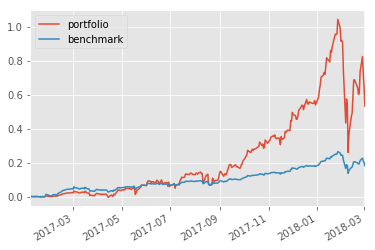

In [13]:
import matplotlib.pyplot as plt
from matplotlib import style


style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SPY.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)

plt.show()

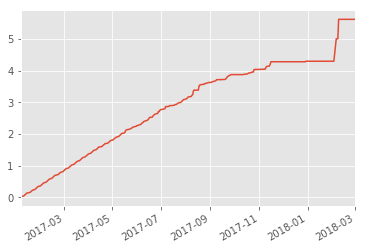

In [10]:
perf.max_leverage.plot()
plt.show()